# Markov Decision Process (MDP)

### Ransalu Senanayake

In [47]:
import copy
import timeit
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
from ipywidgets import interactive
import ipywidgets as widgets

Create the following grid world.

**States:** A 10x10 grid

**Actions:** Up, Down, Left, Right

**Tranistion probabilities:**
* 0.7 in the direction of action
* 0.1 in the three other directions
* The robot bounces back to the same state near edges

**Rewards:**
* (7,8) has a reward +10
* (2,7) has a reward +3
* (4,3) has a reward -5
* (7,3) has a reward -10
* No reward in other states

This example is based on Decision Making Under Uncertainty by M.J. Kochenderfer.

In [48]:
# Let's define MDP parameters
def createGrid10World():
    def xy2s(y, x):
        x = max(x, 0)
        y = max(y, 0)
        x = min(x, 9)
        y = min(y, 9)
        out = np.ravel_multi_index(np.array([x, y]), (10, 10))
        return out

    def s2xy(s):
        x, y = np.unravel_index(s, (10, 10))
        return y, x

    def gridPlot(ax, im, title='', cmap='Blues'):
        pl.imshow(im, interpolation='none', cmap=cmap, origin='lower')
        pl.colorbar()
        ax.set_xticks(np.arange(0, 10, 1))
        ax.set_yticks(np.arange(0, 10, 1))
        ax.set_xticklabels(np.arange(0, 10, 1))
        ax.set_yticklabels(np.arange(0, 10, 1))
        ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
        ax.set_yticks(np.arange(-.5, 10, 1), minor=True)
        ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
        pl.title(title)
        return

    A = ['left', 'right', 'up', 'down']
    S = np.arange(100)
    T = np.zeros((len(S), len(A), len(S)))
    R = np.zeros((len(S), len(A)))

    for s in S:
        x, y = s2xy(s)
        if x == 2 and y == 7:
            R[s, :] = 3
        elif x == 7 and y == 8:
            R[s, :] = 10
        else:
            if x == 7 and y == 3:
                R[s, :] = -10
            elif x == 4 and y == 3:
                R[s, :] = -5
            elif x == 0:
                if y == 0 or y == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 0] = -0.7
            elif x == 9:
                if y == 0 or y == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 1] = -0.7
            elif y == 0:
                if x == 0 or x == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 3] = -0.7
            elif y == 9:
                if x == 0 or x == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 2] = -0.7

            for a in A:
                if a == 'left':
                    T[s, 0, xy2s(x - 1, y)] += 0.7
                    T[s, 0, xy2s(x + 1, y)] += 0.1
                    T[s, 0, xy2s(x, y - 1)] += 0.1
                    T[s, 0, xy2s(x, y + 1)] += 0.1
                elif a == 'right':
                    T[s, 1, xy2s(x + 1, y)] += 0.7
                    T[s, 1, xy2s(x - 1, y)] += 0.1
                    T[s, 1, xy2s(x, y - 1)] += 0.1
                    T[s, 1, xy2s(x, y + 1)] += 0.1
                elif a == 'up':
                    T[s, 2, xy2s(x, y + 1)] += 0.7
                    T[s, 2, xy2s(x, y - 1)] += 0.1
                    T[s, 2, xy2s(x - 1, y)] += 0.1
                    T[s, 2, xy2s(x + 1, y)] += 0.1
                elif a == 'down':
                    T[s, 3, xy2s(x, y - 1)] += 0.7
                    T[s, 3, xy2s(x, y + 1)] += 0.1
                    T[s, 3, xy2s(x - 1, y)] += 0.1
                    T[s, 3, xy2s(x + 1, y)] += 0.1

    for a, c_x, c_y in [(0, 0, 0), (0, 0, 9), (1, 9, 0), (1, 9, 9), (2, 0, 9), (2, 9, 9), (3, 0, 0), (3, 9, 0)]:
        R[xy2s(c_x, c_y), a] = -0.8

    discount = 0.9

    nextStates = {}
    for si in range(len(S)):
        for ai in range(len(A)):
            nextStates[(si, ai)] = np.where((T[si, ai, :] != 0) == True)[0]

    return {'S': S, 'A': A, 'T': T, 'R': R, 'discount': discount, 'nextStates': nextStates, 'gridPlot': gridPlot, 'xy2s': xy2s, 's2xy': s2xy}

In [49]:
class MDP():
    def __init__(self):
        pass

    def inbuilt_init(self, mdp_dict):
        self.S = mdp_dict['S']
        self.A = mdp_dict['A']
        self.T = mdp_dict['T']
        self.R = mdp_dict['R']
        self.discount = mdp_dict['discount']
        self.nextStates = mdp_dict['nextStates']
        self.gridPlot = mdp_dict['gridPlot']
        self.xy2s = mdp_dict['xy2s']
        self.s2xy = mdp_dict['s2xy']

In [50]:
# Define the MDP
mdp = MDP()
mdp.inbuilt_init(mdp_dict=createGrid10World())

In [51]:
def iterativePolicyEvaluation(mdp, policy, numIterations=10):
    U = np.zeros(len(mdp.S))
    U_old = copy.copy(U)
    for t in range(numIterations):
        for s in mdp.S:
            U[s] = sum([mdp.T[s, policy, s1] * (mdp.R[s, policy] + mdp.discount * U_old[s1]) for s1 in mdp.nextStates[(s, policy)]])
        U_old = copy.copy(U)
    return U

In [52]:
def valueIteration(mdp, numIterations=1):
    U = np.zeros(len(mdp.S))
    U_old = copy.copy(U)
    for t in range(numIterations):
        for s in mdp.S:
            U[s] = max([sum([mdp.T[s, a, s1] * (mdp.R[s, a] + mdp.discount * U_old[s1]) for s1 in mdp.nextStates[(s, a)]]) for a in range(len(mdp.A))])
        U_old = copy.copy(U)
    return U

In [53]:
def policyExtration(mdp, U):
    policy = np.zeros(len(mdp.S), dtype=int)
    for s in mdp.S:
        policy[s] = np.argmax([sum([mdp.T[s, a, s1] * (mdp.R[s, a] + mdp.discount * U[s1]) for s1 in mdp.nextStates[(s, a)]]) for a in range(len(mdp.A))])
    return policy

In [54]:
def qLearning(mdp, numEpisodes=10000, alpha=0.1, epsilon=0.1):
    Q = np.zeros((len(mdp.S), len(mdp.A)))

    for episode in range(numEpisodes):
        s = np.random.choice(mdp.S)  # Initial state randomly selected
        is_terminal = False  # Define terminal condition, if applicable

        while not is_terminal:
            if np.random.rand() < epsilon:
                a = np.random.choice(len(mdp.A))
            else:
                a = np.argmax(Q[s, :])

            # Get possible next states
            possible_next_states = mdp.nextStates[(s, a)]

            if possible_next_states.size == 0:
                break

            next_s = np.random.choice(possible_next_states,
                                      p=mdp.T[s, a, possible_next_states])

            reward = mdp.R[s, a]
            Q[s, a] += alpha * (reward + mdp.discount * np.max(Q[next_s, :]) - Q[s, a])

            s = next_s

            # Set a condition if a terminal state is reached (optional)
            # if terminal condition here:
            #     is_terminal = True

    policy = np.argmax(Q, axis=1)
    return Q, policy

In [55]:
# Measure execution time and convergence for Value Iteration and Q-Learning
numIterations = 10

In [56]:
# Value Iteration
start_time = timeit.default_timer()
U_vi = valueIteration(mdp, numIterations=numIterations)
policy_vi = policyExtration(mdp, U=U_vi)
elapsed_vi = timeit.default_timer() - start_time
print('Value Iteration time =', np.round(elapsed_vi * 1000, 2))

Value Iteration time = 31.23


In [57]:
# Q-Learning
start_time = timeit.default_timer()
Q_ql, policy_ql = qLearning(mdp, numEpisodes=10000, alpha=0.1, epsilon=0.1)
elapsed_ql = timeit.default_timer() - start_time
print('Q-Learning time =', np.round(elapsed_ql * 1000, 2))

Q-Learning time = 9190.9


In [58]:
# Plotting the utilities
pl.figure(figsize=(10, 5))

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

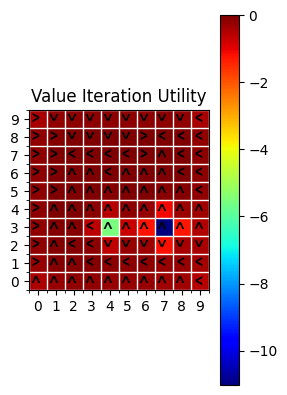

In [59]:
# Utility from Value Iteration
pl.subplot(1, 2, 1)
mdp.gridPlot(ax=pl.gca(), im=U_vi.reshape(10, 10), title='Value Iteration Utility', cmap='jet')
for s in range(100):
    x, y = mdp.s2xy(s)
    if policy_vi[s] == 0:
        m = '\u02C2'
    elif policy_vi[s] == 1:
        m = '\u02C3'
    elif policy_vi[s] == 2:
        m = '\u02C4'
    elif policy_vi[s] == 3:
        m = '\u02C5'
    pl.text(x - 0.5, y - 1, m, color='k', size=20)

pl.show()

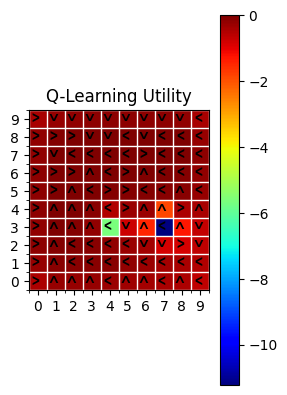

In [60]:
# Q-values from Q-Learning
pl.subplot(1, 2, 2)
mdp.gridPlot(ax=pl.gca(), im=np.max(Q_ql, axis=1).reshape(10, 10), title='Q-Learning Utility', cmap='jet')
for s in range(100):
    x, y = mdp.s2xy(s)
    if policy_ql[s] == 0:
        m = '\u02C2'
    elif policy_ql[s] == 1:
        m = '\u02C3'
    elif policy_ql[s] == 2:
        m = '\u02C4'
    elif policy_ql[s] == 3:
        m = '\u02C5'
    pl.text(x - 0.5, y - 1, m, color='k', size=20)

pl.show()